# Objective

This notebook runs the SpotAnnotationAnalysis pipeline on the results of smfish_0.png from the smfish zoom test.


# I/O

- In: json file containing worker annotations from Quantius.
- Out: pandas dataframe containing reliable* cluster centroids.

In [22]:
from SpotAnnotationAnalysis import SpotAnnotationAnalysis
from QuantiusAnnotation import QuantiusAnnotation
import util
import math
import pandas as pd
import numpy as np

#### Instantiate a BaseAnnotation object and a SpotAnnotationAnalysis object.

In [24]:
json_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/zoom_sm_fish_test.json'
img_name = 'smfish_0'
img_filename = img_name + '.png'
img_filepath = '/Users/jenny.vo-phamhi/Documents/FISH-annotation/Annotation/zoom_test/smfish_0.png'
csv_filepath = None

qa = QuantiusAnnotation(json_filepath, img_filename)
sa = SpotAnnotationAnalysis(qa)
anno_all = qa.df()

#### Cluster annotations.

In [3]:
clustering_params = ['AffinityPropagation', -700]
clusters = sa.get_clusters(anno_all, clustering_params)
util.print_head(clusters)

  centroid_x centroid_y                                            members
0        344        156  [[344, 156, 1084, A3SCM7PCCL3HYR], [343, 154, ...
1        480         81  [[480, 81, 889, A3SCM7PCCL3HYR], [477, 74, 126...
2        668        135  [[668, 135, 924, A3SCM7PCCL3HYR], [666, 130, 7...
3        585        104  [[585, 104, 1154, A3SCM7PCCL3HYR], [582, 102, ...
4        627         48  [[627, 48, 1234, A3SCM7PCCL3HYR], [629, 49, 95...


In [4]:
img_height = anno_all['height'].values[0]

<Figure size 864x504 with 0 Axes>

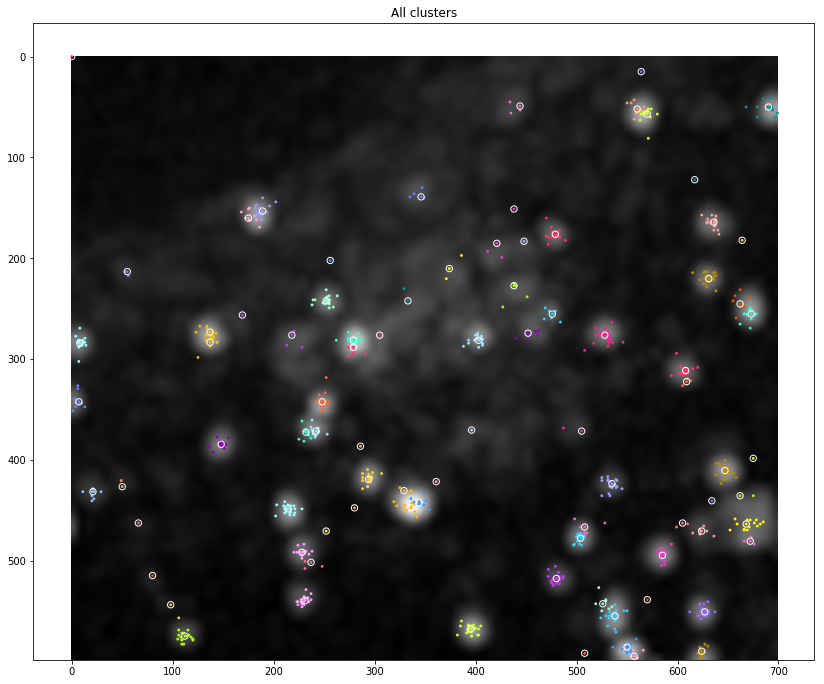

In [5]:
show_workers = True
show_centroids = True
x_bounds, y_bounds, show_ref_points = None, None, False
worker_marker_size, cluster_marker_size, ref_marker_size, bigger_window_size = 8, 40, None, True
plot_title = 'All clusters'
util.visualize_clusters(clusters, show_workers, show_centroids, show_ref_points, worker_marker_size, cluster_marker_size, ref_marker_size, csv_filepath, img_filepath, img_height, x_bounds, y_bounds, plot_title, bigger_window_size)

### Get large clusters
#### Sort clusters by number of unique annotators. Visualize cluster size threshold.

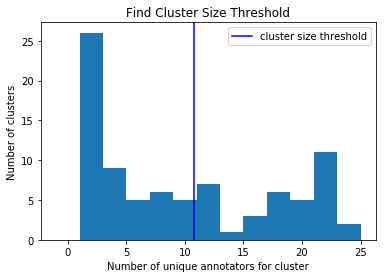

In [6]:
cluster_size_threshold = util.get_cluster_size_threshold(clusters)
small_clusters, large_clusters = util.sort_clusters_by_size(clusters, cluster_size_threshold)
util.plot_cluster_size_threshold(clusters, cluster_size_threshold)

<Figure size 864x504 with 0 Axes>

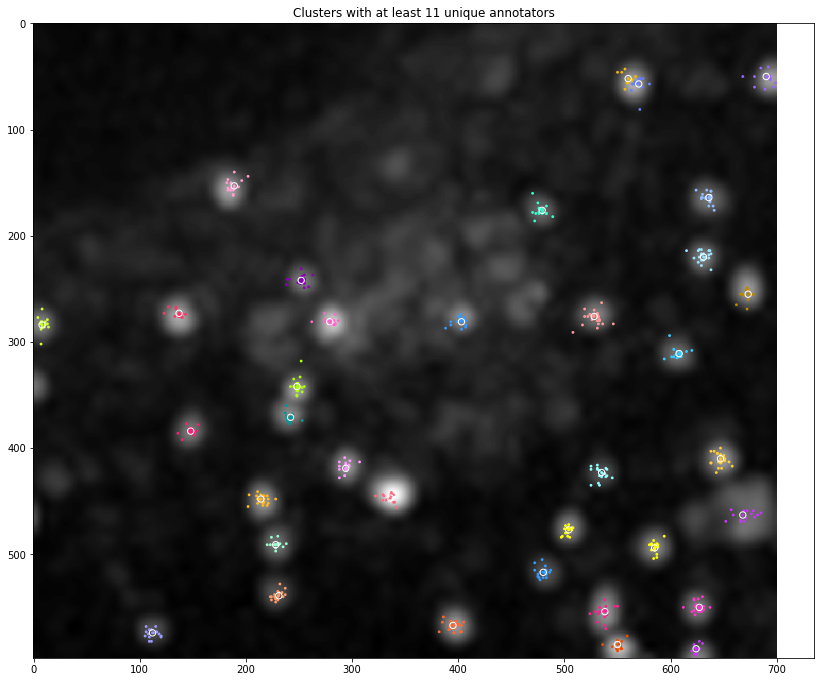

In [7]:
plot_title = 'Clusters with at least ' + str(math.ceil(cluster_size_threshold)) + ' unique annotators'
util.visualize_clusters(large_clusters, show_workers, show_centroids, show_ref_points, worker_marker_size, cluster_marker_size, ref_marker_size, csv_filepath, img_filepath, img_height, x_bounds, y_bounds, plot_title, bigger_window_size)

### Get clumpy clusters
#### Sort clusters by fraction of unique annotators who contribute more than once and visualize the clumpiness threshold.

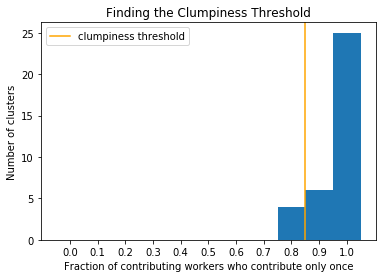

In [8]:
clumpiness_threshold = util.plot_clumpiness_threshold(large_clusters)
clumpy_clusters, nonclumpy_clusters = util.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)

#### Plot clusters identified as "clumpy."

<Figure size 864x504 with 0 Axes>

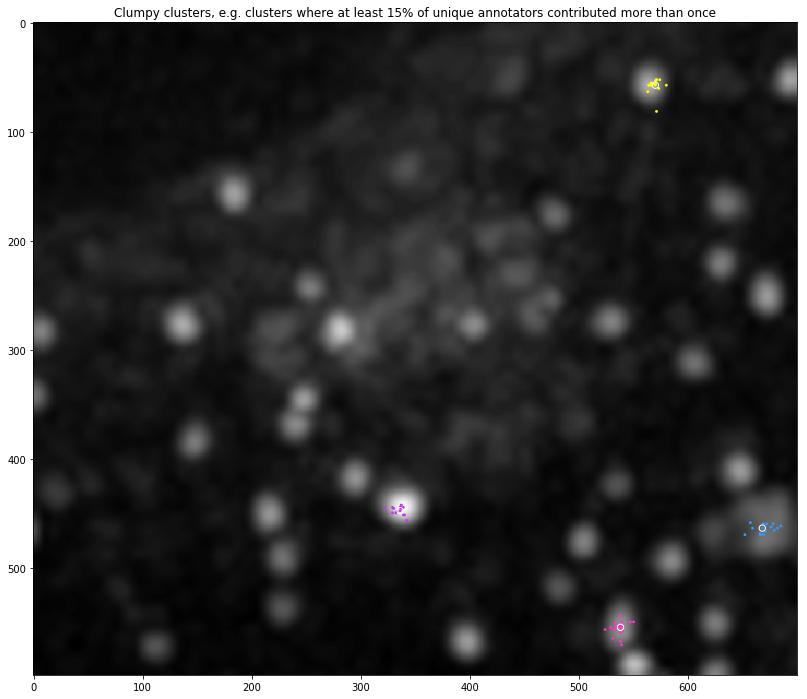

In [9]:
show_workers = True
show_centroids = True
plot_title = 'Clumpy clusters, e.g. clusters where at least ' + str(math.floor(100*(1-clumpiness_threshold))) + '% of unique annotators contributed more than once'
util.visualize_clusters(clumpy_clusters, show_workers, show_centroids, show_ref_points, worker_marker_size, cluster_marker_size, ref_marker_size, csv_filepath, img_filepath, img_height, x_bounds, y_bounds, plot_title, bigger_window_size)

#### Partition clumpy clusters and add the results of partitioning to the dataframe of large, nonclumpy clusters.

In [10]:
declumping_params = ['KMeans', 2]

result_clusters = nonclumpy_clusters
for i in range(len(clumpy_clusters.index)):
    
    # actual functionality
    subclusters = util.declump(clumpy_clusters, i, declumping_params)
    result_clusters = pd.concat([subclusters, result_clusters], ignore_index=True)

#### Visualize all resulting clusters (including original nonclumpy and newly declumped).

<Figure size 864x504 with 0 Axes>

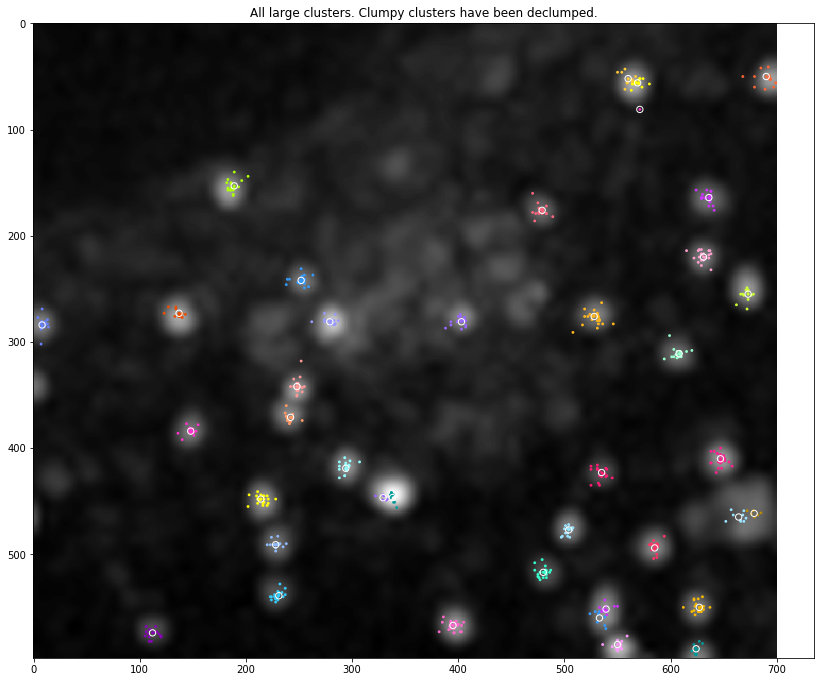

In [11]:
plot_title = 'All large clusters. Clumpy clusters have been declumped.'
util.visualize_clusters(result_clusters, show_workers, show_centroids, show_ref_points, worker_marker_size, cluster_marker_size, ref_marker_size, csv_filepath, img_filepath, img_height, x_bounds, y_bounds, plot_title, bigger_window_size)

In [25]:
result_centroids = result_clusters.as_matrix(columns=['centroid_x', 'centroid_y'])
np.savetxt(img_name + '_coords.csv', result_centroids, delimiter=",", comments='', header = "centroid_x,centroid_y")